In [13]:
%matplotlib inline
%config IPCompleter.greedy=True

In [14]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
# from models.schemas import Base, DublinBike
# from config import MySQL
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.externals import joblib
import lightgbm as lgb

#Using pre-loaded pickle data to do data analysis
bike_df = pd.read_pickle("./bike_df.pkl")
weather_df = pd.read_pickle("./weather_df.pkl")

In [15]:
def labeling(df):
    df['available_bike_ratio'] = df['available_bike'] / df['bike_stand']
    df['available_bike_ratio_label'] = df['available_bike_ratio'].shift(-219744)
    df.dropna(inplace=True)
    return df

In [16]:
'''Using ratio as the label for future training'''
def labeling_eval(df):
    df['available_bike_ratio'] = df['available_bike'] / df['bike_stand']
    return df

In [17]:
'''Combine bike an weather dataframe'''
def merge_df(bike_df, weather_df):
    combined_df = pd.merge(bike_df, weather_df,  how='inner',\
                           left_on=['number', 'scraping_time'],\
                           right_on = ['stationNum', 'datetime'],\
                           suffixes=('_bike','_weather'))
    return combined_df

In [18]:
'''Extract hour of the day'''
def datetime_conversion(df, df_col):
    df['hour'] = df[df_col].dt.hour
    return df

In [19]:
'''Remove outlier before training'''
def remove_outlier(df):    
    df = df[np.abs(df["available_bike_ratio_label"]-df["available_bike_ratio_label"].mean())<=(3*df["available_bike_ratio_label"].std())]
    return df

In [20]:
def timestamp_to_time(df, col):
    df[col] = pd.to_datetime(df[col], unit='s')
    return df

In [21]:
'''Feature engineeer the time feature to cyclic sine cosine representation'''
def time_transform(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df = df.drop([col], axis = 1)
    return df

In [22]:
 '''Drop redundant columns'''
def data_cleaning(df):
    pd.set_option('display.max_columns', 500)
    col_to_drop = ['address', 'site_names','bonus', 'last_update', 'datetime','icon', 'lon', 'lat', 'stationNum','available_bike_stand','description','status','sunset']
    df = df.drop(col_to_drop, axis = 1)
    df = df.drop_duplicates().reset_index()
    df = df.drop(['index'] ,axis = 1)
    df = df.drop(['scraping_time','available_bike'] ,axis = 1)

    return df

In [23]:
'''Convert data type'''
def data_type_conversion(df):
    df['banking'] = df['banking'].astype('int32')
    df['code'] = df['code'].astype('int32') // 100
    df['temperature'] = df['temperature'].astype('float64')
#     status_map = {'OPEN':1,'CLOSE':0}
#     df['status'] = df['status'].map(status_map)
    return df

In [24]:
'''Convert deal with the categorical feature to multi-dimension 0 and 1'''
def one_hot_encoding(df, col_list):
    df = pd.get_dummies(df, prefix = col_list, columns = col_list)
    return df

In [25]:
bike_df = labeling(bike_df)
combined_df = merge_df(bike_df, weather_df)
combined_df = datetime_conversion(combined_df, "scraping_time")
combined_df_no_outl = remove_outlier(combined_df)
combined_df_no_outl

,scraping_time,number,last_update,address,site_names,latitude,longitude,bike_stand,available_bike_stand,available_bike,...,icon,lon,lat,wind_spd,clouds,sunset,code,weekday,stationNum,hour
0,2020-03-24 10:52:00,2,2020-03-24 10:46:25,Blessington Street,BLESSINGTON STREET,53.3568,-6.26814,20,3,17,...,04d,-6.27,53.36,1.0,75.0,1585075524,803,2,2,10
1,2020-03-24 10:52:00,3,2020-03-24 10:50:43,Bolton Street,BOLTON STREET,53.3512,-6.26986,20,11,9,...,04d,-6.27,53.35,2.6,75.0,1585075523,803,2,3,10
2,2020-03-24 10:52:00,4,2020-03-24 10:47:27,Greek Street,GREEK STREET,53.3469,-6.27298,20,6,14,...,04d,-6.27,53.35,2.6,75.0,1585075523,803,2,4,10
3,2020-03-24 10:52:00,5,2020-03-24 10:41:25,Charlemont Street,CHARLEMONT PLACE,53.3307,-6.26018,40,18,22,...,04d,-6.26,53.33,2.6,75.0,1585075520,803,2,5,10
4,2020-03-24 10:52:00,6,2020-03-24 10:46:54,Christchurch Place,CHRISTCHURCH PLACE,53.3434,-6.27012,20,14,6,...,04d,-6.27,53.34,1.0,75.0,1585075523,803,2,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281578,2020-04-02 10:50:02,36,2020-04-02 10:48:53,St. Stephen's Green East,ST. STEPHEN'S GREEN EAST,53.3378,-6.25603,40,32,8,...,c04d,-6.26,53.34,11.3,75.0,1585854094,803,4,36,10
281579,2020-04-02 10:50:02,37,2020-04-02 10:47:22,St. Stephen's Green South,ST. STEPHEN'S GREEN SOUTH,53.3375,-6.26199,30,17,12,...,c04d,-6.26,53.34,11.3,75.0,1585854094,803,4,37,10
281580,2020-04-02 10:50:02,38,2020-04-02 10:47:48,Talbot Street,TALBOT STREET,53.3510,-6.25294,40,15,25,...,c04d,-6.25,53.35,11.3,75.0,1585854092,803,4,38,10
281581,2020-04-02 10:50:02,39,2020-04-02 10:48:34,Wilton Terrace,WILTON TERRACE,53.3324,-6.25272,20,9,11,...,c04d,-6.25,53.33,11.3,75.0,1585854091,803,4,39,10


In [26]:
print ("Shape Of The Before Ouliers: ",combined_df.shape)
print ("Shape Of The After Ouliers: ",combined_df_no_outl.shape)

Shape Of The Before Ouliers:  (281583, 28)
Shape Of The After Ouliers:  (279770, 28)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


[Text(0, 0.5, 'Label'), Text(0.5, 0, 'code')]

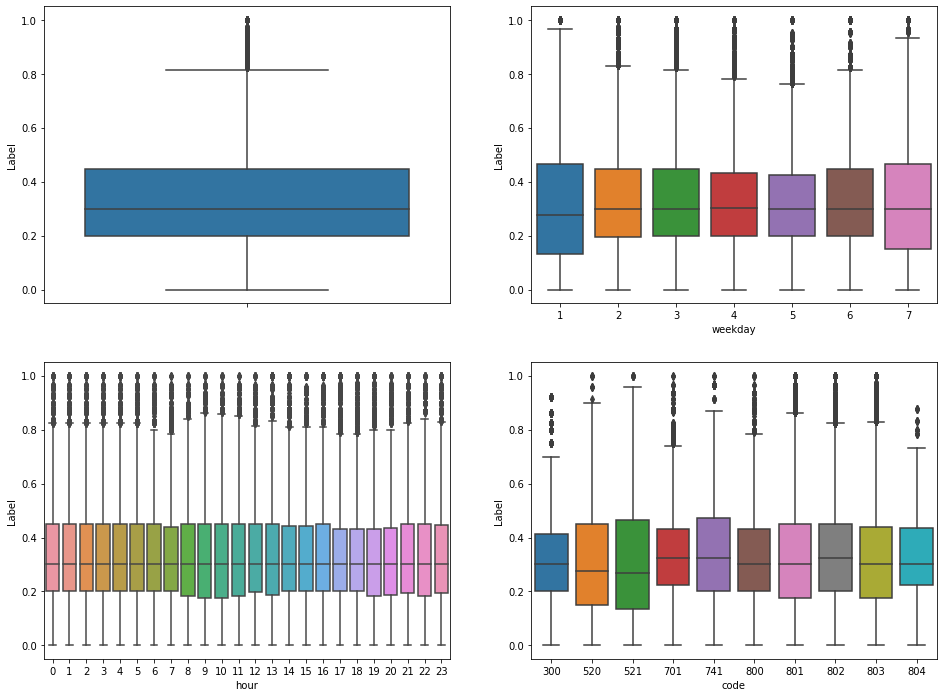

In [27]:
%time
#Analyze the distribution of bike availibility in categorical feature
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(16,12))
sns.boxplot(data=combined_df,y="available_bike_ratio_label",orient="v",ax=axes[0][0])
sns.boxplot(data=combined_df,y="available_bike_ratio_label",x="weekday",orient="v",ax=axes[0][1])
sns.boxplot(data=combined_df,y="available_bike_ratio_label",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=combined_df,y="available_bike_ratio_label",x="code",orient="v",ax=axes[1][1])
axes[0][0].set(ylabel='Label')
axes[0][1].set(xlabel='weekday', ylabel='Label')
axes[1][0].set(xlabel='hour', ylabel='Label')
axes[1][1].set(xlabel='code', ylabel='Label')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


[Text(0, 0.5, 'Label'), Text(0.5, 0, 'temperature')]

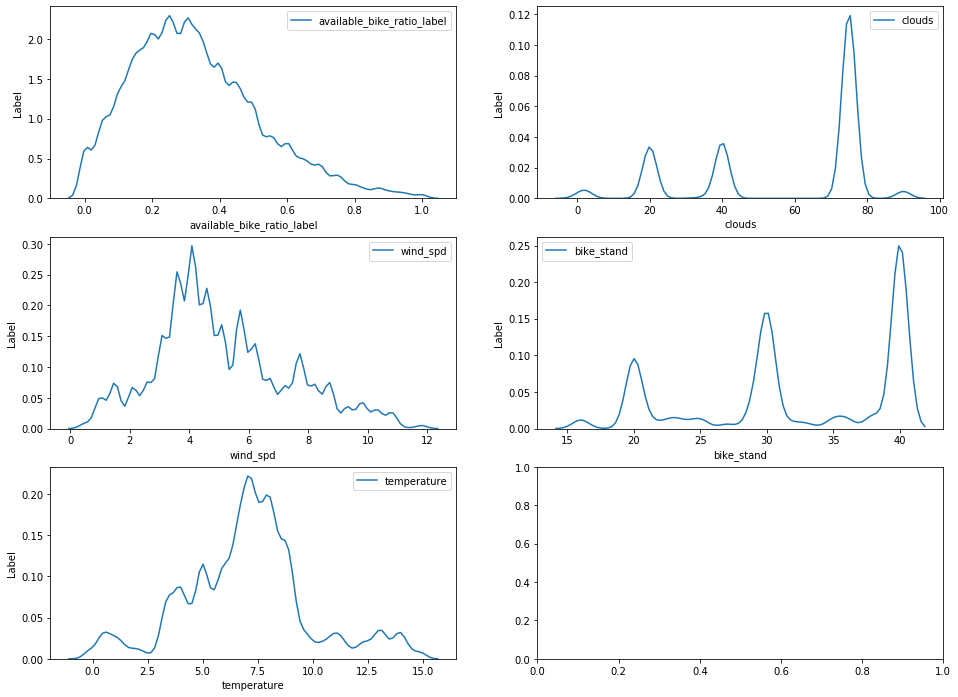

In [28]:
%time
# Analyze the distribution of bike availibility in continuous feature
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(16,12))
sns.kdeplot(data=combined_df["available_bike_ratio_label"],ax=axes[0][0])
sns.kdeplot(data=combined_df["clouds"],ax=axes[0][1])
sns.kdeplot(data=combined_df["wind_spd"],ax=axes[1][0])
sns.kdeplot(data=combined_df["bike_stand"],ax=axes[1][1])
sns.kdeplot(data=combined_df["temperature"],ax=axes[2][0])

axes[0][0].set(xlabel='available_bike_ratio_label', ylabel='Label')
axes[0][1].set(xlabel='clouds', ylabel='Label')
axes[1][0].set(xlabel='wind_spd', ylabel='Label')
axes[1][1].set(xlabel='bike_stand', ylabel='Label')
axes[2][0].set(xlabel='temperature', ylabel='Label')

In [29]:
combined_df_no_outl['temperature'] = combined_df_no_outl['temperature'].astype('float64')

/Users/pie_trick/opt/anaconda3/envs/dublin-bikes/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


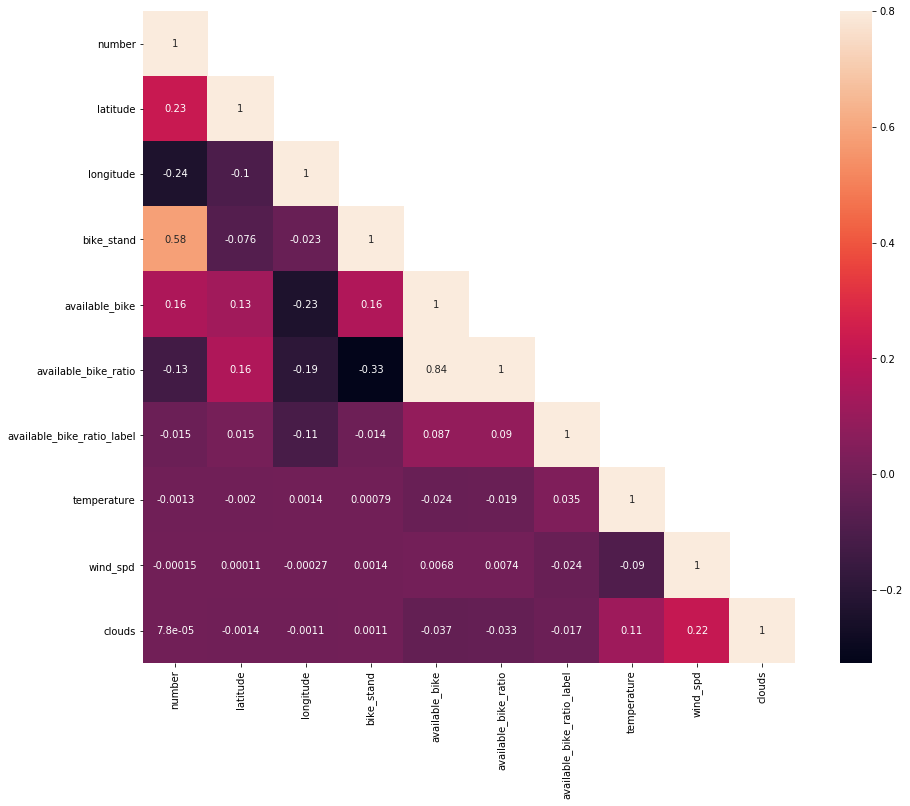

In [30]:
#Finding correlation of continuous features
corrMatt = combined_df_no_outl[['number', 'latitude', 'longitude', 'bike_stand', 'available_bike', 'available_bike_ratio','available_bike_ratio_label', 'temperature', 'wind_spd', 'clouds', 'sunset', 'code']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots(figsize=(16,12))
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

CPU times: user 3.85 s, sys: 45 ms, total: 3.9 s
Wall time: 3.9 s


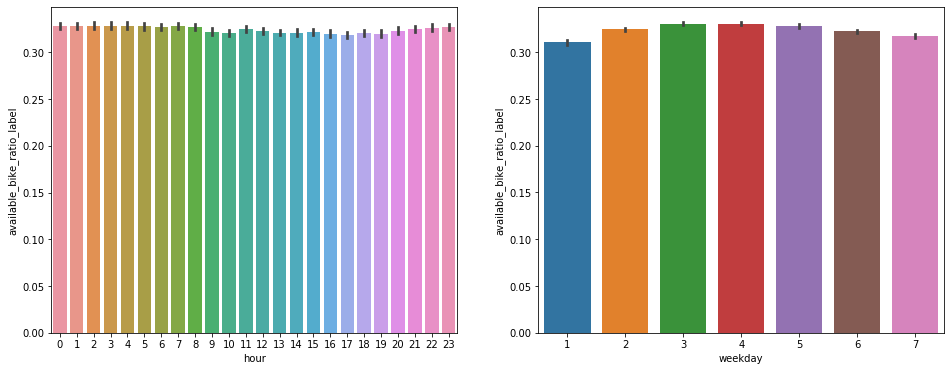

In [31]:
%%time
#Finding distribution between different time
fig, axes = plt.subplots(ncols=2, figsize=(16,6))
sns.barplot(data = combined_df_no_outl, y = 'available_bike_ratio_label', x = 'hour', ax=axes[0])
sns.barplot(data = combined_df_no_outl, y = 'available_bike_ratio_label', x = 'weekday', ax=axes[1])

In [32]:
combined_df_no_outl = data_type_conversion(combined_df_no_outl)
combined_df_no_outl = data_cleaning(combined_df_no_outl)
combined_df_no_outl = time_transform(combined_df_no_outl, 'weekday', 7)
combined_df_no_outl = time_transform(combined_df_no_outl, 'hour', 23)

/Users/pie_trick/opt/anaconda3/envs/dublin-bikes/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pie_trick/opt/anaconda3/envs/dublin-bikes/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/pie_trick/opt/anaconda3/envs/dublin-bikes/lib/python3.7/site-packages/ipykernel_launcher.py

In [33]:
combined_df_no_outl.dtypes

number                          int64
latitude                      float64
longitude                     float64
bike_stand                      int64
banking                         int32
available_bike_ratio          float64
available_bike_ratio_label    float64
temperature                   float64
wind_spd                      float64
clouds                        float64
code                            int32
weekday_sin                   float64
weekday_cos                   float64
hour_sin                      float64
hour_cos                      float64
dtype: object

In [34]:
y_train = combined_df_no_outl['available_bike_ratio_label']
x_train = combined_df_no_outl.loc[:, combined_df_no_outl.columns != 'available_bike_ratio_label']

In [35]:
size = len(x_train) * 9 //10 
x_train, x_test = x_train[:size], x_train[size:]
y_train, y_test = y_train[:size], y_train[size:]
print(size)

251793


In [36]:
len(x_test.columns)

14

In [37]:
'''Hyperparameter tuning'''
# %%time
# fit_params = {"early_stopping_rounds" : 50, 
#              "eval_set" : [(x_test, y_test)],
#              'eval_names': ['valid'],
#              'verbose': 0}

           
# param_test = {'learning_rate' : [ 0.005, 0.01, 0.02],
#               'n_estimators' : [800, 900, 1000, 1100,1200],
#               'num_leaves': [40, 50, 60, 70, 80, 90, 100], 
#               'min_child_samples': [12, 14,15,16,18] ,
#               'max_depth': [10, 20, 30, 40, 50],
#               'reg_lambda': [5, 10, 15, 20],
#               'min_data_in_leaf' : [5,10,15,20,25,30,35,40,45], 
#               'min_gain_to_split':[0.01,0.02,0.03, 0.05, 0.08, 0.1]}

# #number of combinations
# n_iter = 10000


# #intializing lgbm and lunching the search
# lgb_reg = lgb.LGBMRegressor(boosting ='gbdt', random_state=42, silent=True, n_jobs=-1)
# grid_search = RandomizedSearchCV(
#     estimator=lgb_reg, param_distributions=param_test, 
#     n_iter=n_iter,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     refit=True,
#     random_state=42,
#     verbose=1, n_jobs=-1)

# grid_search.fit(x_test, y_test, **fit_params)
# print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

# opt_parameters =  grid_search.best_params_

'Hyperparameter tuning'

In [38]:
opt_parameters = { 'learning_rate': 0.02,
                      'max_depth': 10,
                      'min_child_samples': 12,
                      'min_data_in_leaf': 20,
                      'min_gain_to_split': 0.01,
                      'n_estimators': 1200,
                      'num_leaves': 50,
                      'reg_lambda': 5}

In [39]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(opt_parameters)

{ 'learning_rate': 0.02,
  'max_depth': 10,
  'min_child_samples': 12,
  'min_data_in_leaf': 20,
  'min_gain_to_split': 0.01,
  'n_estimators': 1200,
  'num_leaves': 50,
  'reg_lambda': 5}


In [40]:
%%time
#Model validation
lgb_turned = lgb.LGBMRegressor(**opt_parameters)
lgb_turned.fit(x_train, y_train)
scores=cross_val_score(lgb_turned, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print('{:.5f}'.format(np.mean(scores)))

-0.14118
CPU times: user 4min 48s, sys: 4.65 s, total: 4min 53s
Wall time: 40.3 s


In [41]:
model_name = 'lgbm_model_daily.pkl'
joblib.dump(lgb_turned, model_name)

['lgbm_model_daily.pkl']

In [42]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 3.28 s, sys: 32.1 ms, total: 3.32 s
Wall time: 498 ms


In [43]:
y_test = y_test.reset_index()["available_bike_ratio_label"]
mean_squared_error(y_test, y_prediction, squared=False)

0.17135369989985733

In [44]:
y_prediction = pd.Series(y_prediction)
capacity = x_test['bike_stand'].reset_index().drop(['index'], axis = 1).squeeze()

In [45]:
y_prediction_inv = capacity.multiply(y_prediction)
y_test_inv = capacity.multiply(y_test)

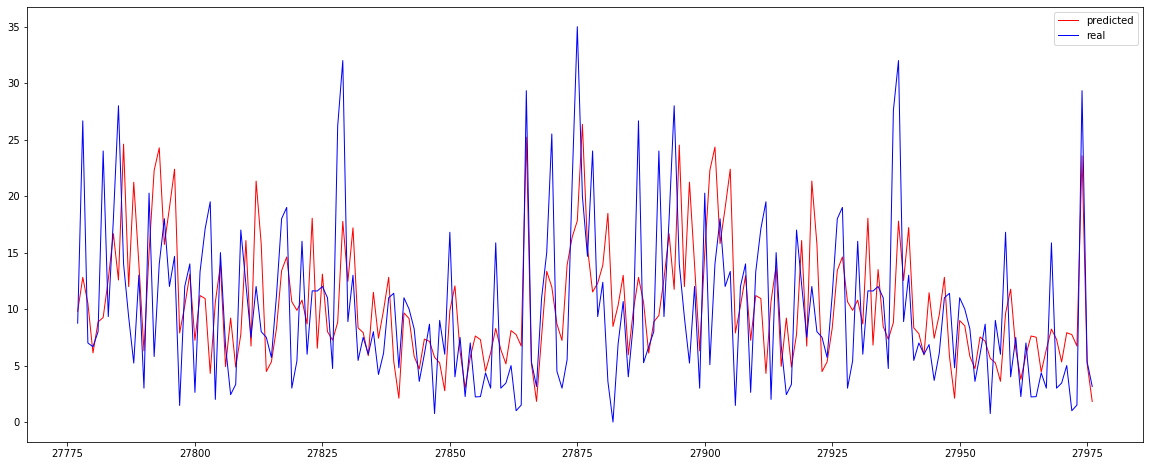

In [51]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(y_prediction_inv[-200:], linewidth=1, color = 'red', label = 'predicted')
plt.plot(y_test_inv[-200:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()